In [9]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets

In the previous chapter I introduces logistic regression and how it make prediction. I as well pointed out, that unlike Perceptron, logistic regression returns probability of datapoints belongs to specific class. However, I didn't mention the training algorithm for it. That would be content of this chapter.

I also demonstrated gradient descent algorithm in the second half of the previous chapter. There will be no surprise, that the gradient descent is the exact algorithm we are going to use in this chapter to train logistic regression.

# Logistic regression training

We now should have all the knowledge we need to train logistic regression. For reminder, prediction of the logistic regression is following:

$$
f(\pmb{x})=\frac{1}{1+e^{-\pmb{x}\pmb{w}^T}}
$$

In able to use gradient descent, we need some function, that the algorithm is going to optimize. Thats why I showed loss function. When we plug it in, we obtain the following formula.

$$
\mathcal{L}=\frac{1}{2} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2 = \frac{1}{2} \sum_{i=0}^{n} \left( t_i - \frac{1}{1+e^{-\pmb{x}\pmb{w}^T}} \right)^2
$$

Now we want to update the weights, so we need to compute gradient of loss function in respect to weight (and we need to compute it for every weights). In this case, we can use the chain rule.

$$
\frac{\partial \mathcal{L}}{\partial w_i} = \frac{\partial \mathcal{L}}{\partial f(\pmb{x})} \cdot \frac{\partial f(\pmb{x})}{\partial \pmb{x}\pmb{w}^T} \cdot \frac{\partial \pmb{x}\pmb{w}^T}{\partial w_i}
$$

Then the gradient is easy to obtain (note that I mark $\sigma(x)$ as the sigmoid function, i.e. $\sigma(x)=\frac{1}{1+e^{-x}}$ and $y_i$ as the prediction of the model, i.e. $y_i = \sigma(\pmb{x}\pmb{w}^T)$.

$$\
\frac{\partial \mathcal{L}}{\partial w_i} = (t_i - y_i) \cdot -\sigma(\pmb{x}\pmb{w}^T)\left( 1 - \sigma(\pmb{x}\pmb{w}^T) \right) \cdot x_i
$$

> Note the minus in the second multiple. Because in the loss is $t_i - f(\pmb{x})$ (minus in front of the prediction), the whole derivative is multiplied by $-1$. We can alternatively ignore the minus sign and then add the gradient to the weights, so the final formula would be $w_i = w_i + \alpha \frac{\partial \mathcal{L}}{\partial w_i}$. I will stick with the proper mathematical formula - the gradient will be multiplied by $-1$ and I will be subtract it from the weights. I just wanted to point this out, as the minus is sometimes forgotten.

Finally, let's put it all to the code.

I will use the same class as in the previous chapter (`Neuron`) and I will implement the fit method. Don't forget that the gradient descent algorithm needs learning, I will put it in the constructor.

In [190]:
class StochasticNeuron:
    def __init__(self, max_iters=100, random_state=None, learning_rate=0.001):
        self.max_iters = max_iters
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        # Learning
        for iteration in range(self.max_iters):
            # shufle data randomly
            permutation = self._rand.permutation(len(X))       
            train_data = X[permutation]
            train_labels = y[permutation]
            # make gradient descent on each data point
            for datapoint, target in zip(train_data, train_labels):
                prediction = self.predict(datapoint)
                # compute gradient
                gradient = -(target - prediction) * (prediction * (1 - prediction)) * datapoint
                # update weights
                self._weights = self._weights - self._learning_rate * gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

The algorithm makes `self.max_iters` iterations and in each iteration, it randomly shuffle the data and perform gradient descent for each data point. That mean the algorithm will make `self.max_iters * len(X)` gradient descent executions during training. Let's see how the algorithm behave on some dataset.

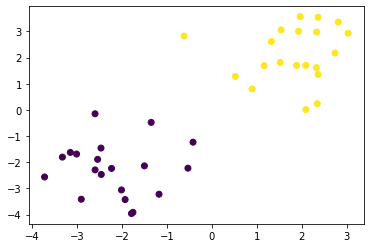

In [58]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=40,
    n_features=2,
    centers=[[-2, -2], [2, 2]],
    random_state=42,
)
plt.scatter(data[:,0], data[:,1], c=classes)
plt.show()

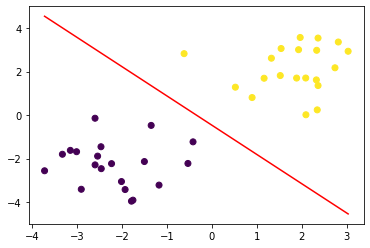

In [191]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
s = StochasticNeuron(random_state=41, max_iters=500, learning_rate=0.01)
s.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - s._weights[0] / s._weights[1]
bias = s._weights[2] / s._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()

And that's it, we have working logistic regression. What we have done is called **Stochastic Gradient Descent** - it computes gradient for every sample and update the weights accordingly.

# Batch gradient descent

Let's think a little bit about the previous implementation. When we treat each datapoint separately, the optimum is "put the separating hyperplane as far as possible". In other word, when we have only one point and we want to minimalize the loss, the ideal separating hyperplane is infinitly far away from the datapoint (as only in infinity is the value of sigmoid 1 or 0, depending on the class). As a result, the algorithm can start oscilating the same way we have seen in the perceptron case.

However, what we really want, is the separating hyperplane that is optimal for all the datapoints we have. Let's look once again to the loss function.

$$
\mathcal{L}=\frac{1}{2} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2 
$$

We silently ignored the sum, or more precisely we used only one datapoint so the sum disapeared. Let's now fix the algorithm and instead of updating the weights based on the simple sample, we are going to update it based on the all the samples.

In [192]:
class GradientNeuron:
    def __init__(self, max_iters=100, random_state=None, learning_rate=0.001):
        self.max_iters = max_iters
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        # Learning
        for iteration in range(self.max_iters):
            # predict the data
            prediction = self.predict(X)
            # table of gradient for each weights and gradient in the shape (samples,weights)
            gradient = np.reshape(-(y - prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * X
            # sum gradient over the samples
            sum_gradient = np.sum(gradient, axis=0)
            # update the weights
            self._weights = self._weights - self._learning_rate * sum_gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

The implementation is almost the same. We first generate all the predictions for all the datapoints (that is `prediction` is vector), then compute the gradient of loss and sigmoid (the result is still a vector) and finally multiply each value with the corresponding datapoint. Because `X` is a matrix, we need to reshape the gradient (of loss in respect to $\pmb{x}\pmb{w}^T$) to matrix of size `(samples,1)` so we can multiply it with matrix `X` of shape `(samples,features)`. We obtain the gradient in respect to input variables for each datapoint (that is `gradient` variable in the shape `(samples,features)`) and we sum it over the datapoints. Finally, we update the weights.

Note that we didn't shuffle the data this time, as it doesn't make sense.

Now let's train the logistic regression and see the results.

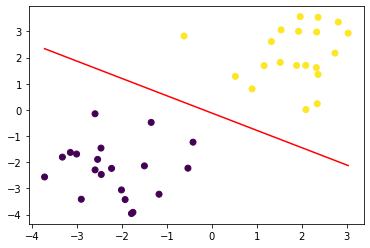

In [193]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
g = GradientNeuron(random_state=42, max_iters=1000, learning_rate=0.05)
g.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - g._weights[0] / g._weights[1]
bias = g._weights[2] / g._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()

The result seems to be a bit better then in the previous case. The algorithm keeps about the same distance from the first class as from the second one. Using all the datapoints at once, the algorithm can find the global minimum and will not oscilate.

Sometimes, this algorithm is just call **gradient descent** (instead of batch gradient descent). This make sense as the algorithm in fact optimize the global loss (instead of loss for individual datapoints). In most sources gradient descent (aka batch gradient descent) is shown first and then they start talking about it's stochastic version. I decided to flip the order as from the implementation point of view, the stochastic version is easier to read (at least I believe so).

## Pros and cons

Now, when we have seen batch gradient descent (I will refer to it as gradient descent so on) and stochastic gradient descent, we should talk about the differences and what are their pros and cons.

+ Gradient descent is more stable and can result in faster convergence in some cases.
+ Gradient descent is usually more eficient, as the operations can be vectorized (performing the same operation over multiple data at once) and thus the algorithm can be faster.
+ Because update is following the prediction, the algorithm can be paralelized into some level.
+ Gradient descent can stuck in the local optimum more easily.
+ Gradient descent can have problems for big training sets, as the data don't need to fit into memory (nothing we would need to worry about so far). That may leads even to overflow, when there are so many samples that the sum of gradients do not fit into to memory (or the value would be simply too big).
+ Stochastic gradient descent updates weights more often and thus can lead to faster convergence.
+ Stochastic gradient descent is more computationally intensive.
+ Stochastic gradient descent can oscilate too much and avoid the global optimum (even good local optimum).

These algorithms are extrems, we update weights for every datapoint or for all the datapoints. It turns out the best approach is something between, that lead us to the following algorithm.

# Minibatch gradient descent

Minibatch gradient descent combines the approaches above. We provide the algorithm another parameter (called batch size). Before each iteration, the algorithm shuffle the data and split them into subsets of the same size (based on the batch size parameter) called batches. The weights update is then done for each batch separatelly.

There is usually one more difference to batch gradient descent. We sum the gradients before and it turns out, it is better to use mean. Because we use mean, the order of gradient remains same no matter what batch size we use. Moreover, the algorithm became more stable (the gradients are less noisy) and we can control the speed of algorithm using `learning_rate` parameter. Note that in order to keep same speed of training, we need to multiply the learning rate by $2$ if we use twice as big batch size.

Question you may ask is what to do with the last batch in case the number of datapoints is not divisible by the batch size. Well, we can ignore that batch or use it anyway. Note that the batch size should be in order of magnitudes smaller than the data, so skipping it shoudn't have impact on the training process. When we use it, the gradient can be more noisy, but again, it shoudn't have impact on the training process as there are plenty of batches. I am going to use it, but if you don't want to, it is as easy as modifying the source code a little bit.

Before we dig into the code, I want to point one one small change in the terminology. What we called iteration before is now called epoch - one epoch is done when the algorithm processes all the datapoints in the set. One iteration is then done when one batch is processed.

In [195]:
class MinibatchNeuron:
    def __init__(self, epochs=100, random_state=None, learning_rate=0.001, batch_size=16):
        # use epochs instead of iterations
        self.epochs = epochs
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        n_data = len(X)
        # Learning
        for epoch in range(self.epochs):
            # shuffle the data
            permutation = self._rand.permutation(n_data)
            # for each batch
            for batch_start in range(0, n_data, self._batch_size):
                # get batch
                batch_data = X[permutation[batch_start:batch_start+self._batch_size]]
                batch_target = y[permutation[batch_start:batch_start+self._batch_size]]
                # predict the data
                prediction = self.predict(batch_data)
                # table of gradient for each weights and gradient in the shape (samples,weights)
                gradient = np.reshape(-(batch_target - prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * batch_data
                # mean gradient over the samples
                mean_gradient = np.mean(gradient, axis=0)
                # update the weights
                self._weights = self._weights - self._learning_rate * mean_gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

There are not many changes. First of all, we shuffle the data as we did in the stochastic gradient descent. We then iterate over the data and use Python's slicing capability to obtain one batch (we need to index the original data by the permutations). The rest is the same, except we are using `np.mean` instead of `np.sum`. Let's see the result.

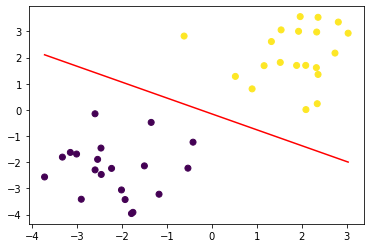

In [196]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
b = MinibatchNeuron(random_state=42, epochs=1000, learning_rate=0.1, batch_size=4)
b.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - b._weights[0] / b._weights[1]
bias = b._weights[2] / b._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()

The result is not surprising. In fact, all the algorithms look0 same so far

# Evaluation